# Adversarial Autoencoder with K-means on MNIST

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.autograd import Variable


# to import MNIST as torch tensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

## training and testing dataloaders

In [2]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 100
# how many epochs for training
num_epochs = 10
# latent space size
z_dim = 10

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## model design

In [3]:
# create an encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, 3, padding=1),            # [batch, 1, 28, 28]
            nn.Dropout2d(p=0.3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                        # [batch, 12, 14, 14]
            nn.Conv2d(12, 24, 5, padding=1),           # [batch, 24, 14, 14]
            nn.Dropout2d(p=0.3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                         # [batch, 24, 7, 7]
        )
        self.latent = nn.Linear(24*6*6, z_dim)

    def forward(self, x):
        x = self.conv(x)
        out = self.latent(x.view(-1, 24*6*6))
        return out

In [4]:
# create a decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(24, 12, 4, stride=2),  # [batch, 12, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 1, 2, stride=2),  # [batch, 1, 28, 28]
            nn.Sigmoid(),
        )
        self.upscale = nn.Sequential(
            nn.Linear(z_dim, 24*6*6),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.upscale(x)
        return self.deconv(output.view(-1, 24, 6, 6))

In [5]:
# create a discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(z_dim, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(True),
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(True),
            nn.Linear(500, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dis(x)
        return x

## CAE model instantiation

In [6]:
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()


optim_dc = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
optim_de = torch.optim.Adam(decoder.parameters(), lr=1e-3)
optim_en = torch.optim.Adam(encoder.parameters(), lr=1e-3)

# set loss function
criterion = nn.MSELoss()
dc_criterion = nn.BCEWithLogitsLoss()
gn_criterion = nn.BCEWithLogitsLoss()

## load wieghts

## training

In [7]:
## training
for x, y in iter(train_loader):
    images = x
grid = torchvision.utils.make_grid(images[-64:])
tb = SummaryWriter()
tb.add_image('images', grid)

x = 0

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    dc_total_loss = 0
    gn_total_loss = 0

    for data in (train_loader):
        x += 1
        img, _ = data
        # Autoencoder training
        embed = encoder(img)
        output = decoder(embed)
        loss = criterion(output, img)
        # back propagation
        optim_en.zero_grad()
        optim_de.zero_grad()
        loss.backward()
        optim_en.step()
        optim_de.step()
        total_loss += loss.item()
        tb.add_scalar('Loss ae/step', loss.item(), x)
        
        
        # GAN training
        for i in range(4):
            # Generating data
            real_distribution = torch.randn(batch_size, z_dim)
            encoder_output = encoder(img).detach()
            # GAN training
            d_real = discriminator(real_distribution)
            d_fake = discriminator(encoder_output)
            optim_dc.zero_grad()
            dc_loss_real = dc_criterion(d_real, Variable(torch.ones(batch_size, 1)))
            dc_loss_real.backward()
            dc_loss_fake = dc_criterion(d_fake, Variable(torch.zeros(batch_size, 1)))
            dc_loss_fake.backward()
            
            optim_dc.step()
        dc_total_loss += 0.5 * (dc_loss_real.item() + dc_loss_fake.item())
        tb.add_scalar('Loss dc/step', 0.5*(dc_loss_real.item() + dc_loss_fake.item()), x)
        # generator training
        optim_en.zero_grad()
        encoder_output = encoder(img)
        d_fake = discriminator(encoder_output)
        gn_loss = gn_criterion(d_fake, Variable(torch.ones(batch_size, 1)))
        
        gn_loss.backward()
        optim_en.step()
        gn_total_loss += gn_loss.item()
        tb.add_scalar('Loss gn/step', gn_loss.item(), x)
    
    # tensorboard stuff
    grid = torchvision.utils.make_grid(output[-64:])
    tb.add_image('images', grid)
    tb.add_histogram('test histo', embed, epoch)    
    tb.add_scalar('Loss ae', total_loss/(60000/batch_size), epoch)
    tb.add_scalar('Loss dc', dc_total_loss/(60000/batch_size), epoch)
    tb.add_scalar('Loss gn', gn_total_loss/(60000/batch_size), epoch)
    
    end_time = time.time()
    # log
    print('epoch [{}/{}], loss dc:{:.4f}, loss gn:{:.4f}, loss ae:{:.4f}, expected runtime:{:.4f} min'
          .format(epoch+1, num_epochs, dc_total_loss/(60000/batch_size), 
                  gn_total_loss/(60000/batch_size), total_loss/(60000/batch_size), 
                  (end_time - start_time)*num_epochs/60))

epoch [1/10], loss dc:0.6872, loss gn:0.6806, loss ae:0.0759, expected runtime:110.7416 min
epoch [2/10], loss dc:0.6918, loss gn:0.6860, loss ae:0.0505, expected runtime:121.2656 min
epoch [3/10], loss dc:0.6911, loss gn:0.6840, loss ae:0.0432, expected runtime:133.2613 min
epoch [4/10], loss dc:0.6916, loss gn:0.6848, loss ae:0.0398, expected runtime:119.2304 min
epoch [5/10], loss dc:0.6919, loss gn:0.6862, loss ae:0.0368, expected runtime:112.2978 min
epoch [6/10], loss dc:0.6919, loss gn:0.6842, loss ae:0.0362, expected runtime:111.9332 min
epoch [7/10], loss dc:0.6917, loss gn:0.6848, loss ae:0.0353, expected runtime:112.2741 min
epoch [8/10], loss dc:0.6917, loss gn:0.6836, loss ae:0.0343, expected runtime:112.4382 min
epoch [9/10], loss dc:0.6914, loss gn:0.6820, loss ae:0.0341, expected runtime:112.7696 min
epoch [10/10], loss dc:0.6916, loss gn:0.6819, loss ae:0.0339, expected runtime:111.2149 min


## visualizing reconstructed results
### NOTE TO SELF: to be automated through DV

In [8]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()
encoder.eval()
decoder.eval()

# get sample outputs
with torch.no_grad():
    output = decoder(encoder(images))
# prep images for display
images = images.numpy()# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

<Figure size 2500x400 with 20 Axes>

## visualizing reconstructions of random latent space
### NOTE TO SELF: to be automated through DV

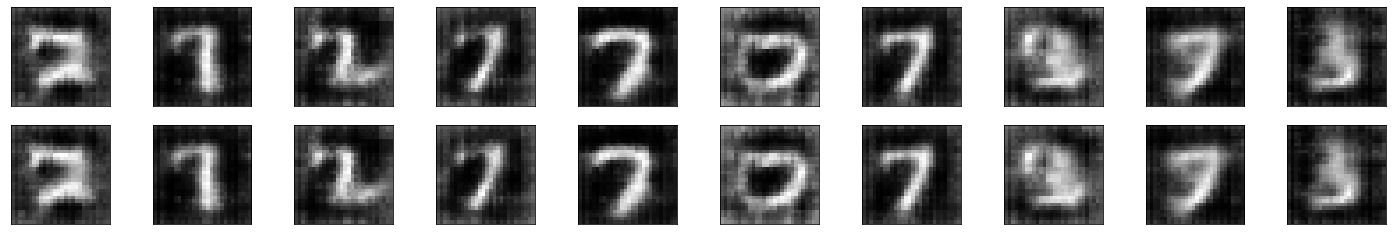

In [9]:
x = torch.randn(batch_size, z_dim)
# get sample outputs
with torch.no_grad():
    output = decoder(x)
# prep i## visualizing reconstructed results
### NOTE TO SELF: to be automated through DVmages for display
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([output, output], axes):
    for img, ax in zip(output, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## reconstruct the train dataset

In [10]:
# run the dataset through the trained model
encoder.eval()
decoder.eval()

for image_index, data in enumerate(train_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    encoded = encoder(images)
    decoded = decoder(encoded)
    if not image_index:
        #First group encoded in new array
        embedded = encoded.detach().numpy()
        #first group decoded
        disembedded = decoded.detach().numpy()
        #labels
        labels = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded = np.vstack((embedded, encoded.detach().numpy()))
    disembedded = np.vstack((disembedded, decoded.detach().numpy()))
    labels = np.hstack((labels, itr_labels.detach().numpy()))

## clustering model instantiation and training

In [11]:
from sklearn.cluster import KMeans

# create a k-means model to cluster the embedded features
clustering_model = KMeans(n_clusters=10, tol = 1e-4, max_iter = 400).fit(embedded)

## visualizing results and performance evaluation

### testing autoencoder

In [12]:
# run the dataset through the trained model
encoder.eval()
decoder.eval()

for image_index, data in enumerate(test_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    encoded = encoder(images)
    decoded = decoder(encoded)    
    if not image_index:
        #First group encoded in new array
        embedded_test = encoded.detach().numpy()
        #first group decoded
        disembedded_test = decoded.detach().numpy()
        #labels
        labels_test = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded_test = np.vstack((embedded_test, encoded.detach().numpy()))
    disembedded_test = np.vstack((disembedded_test, decoded.detach().numpy()))
    labels_test = np.hstack((labels_test, itr_labels.detach().numpy()))

In [13]:
labels_pred = clustering_model.predict(embedded_test)

In [14]:
import import_ipynb
import DataVisuals as dv


view_results = dv.DataVisuals(disembedded.reshape(-1, 28,28), labels, clustering_model.labels_)
view_results_test = dv.DataVisuals(disembedded_test.reshape(-1, 28,28), labels_test, labels_pred)

importing Jupyter notebook from DataVisuals.ipynb


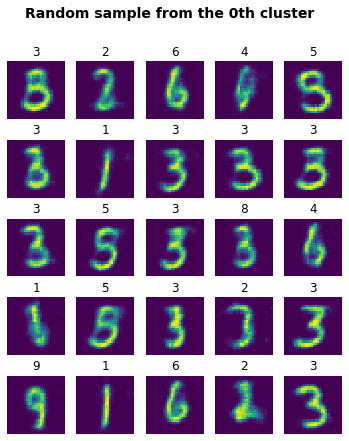

In [15]:
#view reconstructed random samples belonging to the same cluster
view_results.view_lblsample(0)

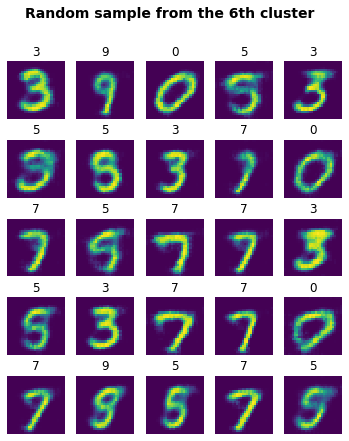

In [16]:
# test data
view_results_test.view_lblsample(6)

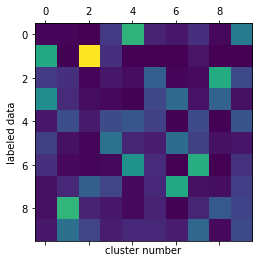

In [17]:
view_results.cm()

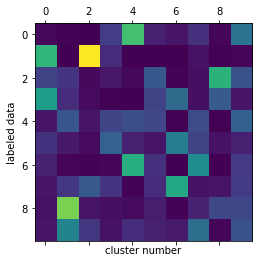

In [18]:
view_results_test.cm()

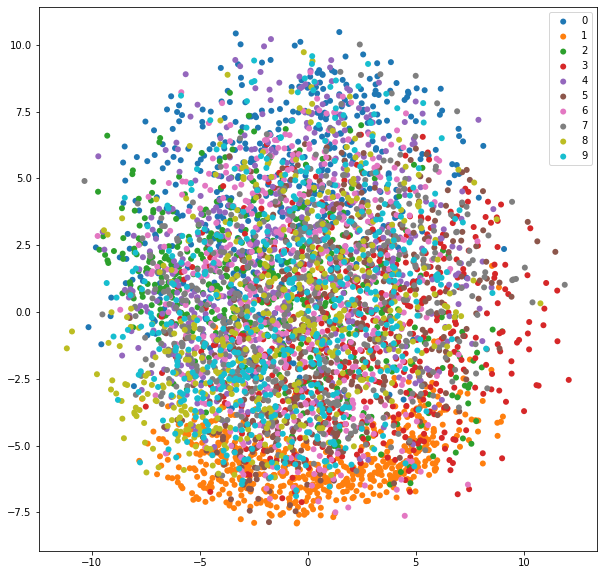

In [19]:
view_results.scat(embedded)

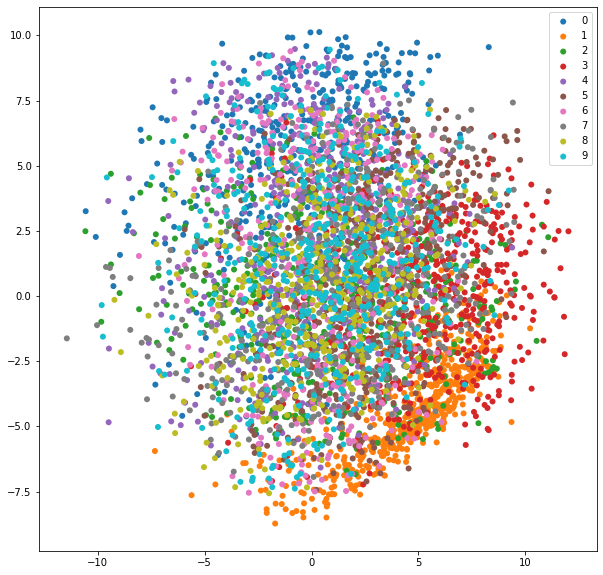

In [20]:
view_results_test.scat(embedded_test)

In [21]:
metric = dv.Metrics(labels, clustering_model.labels_)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.2411 
ARI = 0.1459 
ACC = 0.3365


In [22]:
metric = dv.Metrics(labels_test, labels_pred)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.2520 
ARI = 0.1543 
ACC = 0.3409


## store wieghts